# Using the tiles.zip file for training, validation and test

This notebook explores using the tiles.zip file from the Zenodo Data Available at https://doi.org/10.5281/zenodo.1470797 for training and evaluation of the CNN. Using these files would eliminate the need to perform costly preprocessing of the raw image files.

I wasn't able to find a description of the tiles dataset in the paper, github or suplemental information however as it contains images in the folders `train` `validation` and `test` i'm guessing it contains sufficient data to replicate the paper resuls without using the preprocessing notebooks. It is not clear if what if any preprocessing steps have been taken on these images. 

This notebook explores the completeness of the tiles dataset as compared to the `*.csv` contained in the `data/CSVs/` folder in the repository. I found `3727` total files missing from the  `data/CSVs/` for train, validation and test. I checked the distribution of labels of the missing files by plotting a normalized histogram and discovered they are all negative observations. By adjusting the filename to include the `neg_` prefix I was able to eliminate the missing observations. I believe these files were the manaual created negative observations referenced in the paper. 

I adjusted the `imgagename` attribute in the `*.csv` contained in the `data/CSVs/` folder to reference the filenames of the `tiles` dataset then exported adjusted csvs files for training in notebook 2.1. If the CNN evaluated to similar result as in the paper then I will conclude these files are sufficient for training and evaluation. 

In [1]:
import os
import pandas as pd
import sys

import config as cfg
from utils.utils import walk_dir

In [6]:
csv_path = {
    'train': 'data/CSVs/train.csv',
    'dev': 'data/CSVs/dev.csv',
}

DATA_DIR = cfg.data_dir + '/seg/size_filtered/blobs/'
NEGATIVE_DIR = cfg.data_dir + '/seg/negatives/'
SAVE_DIR = cfg.data_dir + '/models/'
tiles_dir = os.path.join(cfg.data_dir, 'tiles')
export_csv_path = os.path.join('data', 'CSVs')

image_classes = ['cored','diffuse','CAA']


In [8]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [9]:
current_module = sys.modules[__name__]
csvs = ['train', 'dev', 'test']
for csv in csvs:
    print('loading {}'.format(csv))
    setattr(current_module, csv, pd.read_csv(os.path.join('data', 'CSVs', '{}.csv'.format(csv))))
    df = getattr(current_module, csv)
    print(df.shape)
    display(df.head(2))

loading train
(155239, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,10748,NA4757-02_AB/NA4757-02_AB_18_25_61.jpg,1.0,0.000000,0.0,0.0,0.0,0.0
1,29503,NA4918-02_AB17-24/NA4918-02_AB17-24_9_18_12.jpg,0.0,2.832462,0.0,0.0,0.0,0.0


loading dev
(8630, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,0,NA_4896_02_AB17-24/NA_4896_02_AB17-24_0_10_1.jpg,0.0,0.0,0.0,1.0,0.0,0.0
1,0,NA_4896_02_AB17-24/NA_4896_02_AB17-24_0_18_2.jpg,0.0,0.0,0.0,1.0,0.0,0.0


loading test
(10873, 8)


,id,imagename,cored,diffuse,CAA,negative,flag,notsure
0,14,NA4053-02_AB/NA4053-02_AB_18_18.jpg_0.jpg,0.0,3.003472,0.0,0.0,0.28125,1.0
1,15,NA4053-02_AB/NA4053-02_AB_18_18.jpg_1.jpg,0.0,5.214052,0.0,0.0,2.00000,1.0


In [10]:
train['source'] = 'train'
dev['source'] = 'validation' 
test['source'] = 'test'
df_all = pd.concat([train, dev, test])
assert df_all.shape[0] == (train.shape[0] + dev.shape[0] + test.shape[0])

## Distribution of observations
Plotting the distribution of observation for train validation and test will allow us to better understand model performance.


In [11]:
df_all['idx'] = df_all.index
classes = ['cored',
            'diffuse',
            'CAA',
            'negative',
            'flag',
            'notsure',]
id_vars = [c for c in df_all.columns if c not in classes]
dfl = pd.melt(df_all, value_vars=classes,
              id_vars=id_vars)

In [12]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

fig = px.histogram(dfl,
                   x='value',
                   color='variable',
                   nbins=20,
                   facet_row='source',
                   histnorm='percent',
                   title='Portion of classes in Train, Validation and Test')
fig.show()

Looks like some noteable differences in the portion of certain classes between the datasets in the cases of diffuse, cored, and CAA. Stratified sampling might result in more representive performance and evaluation of the model.

## Walk the tiles directory

In [13]:
tile_files = pd.DataFrame(walk_dir(tiles_dir))
print(tile_files.shape)
display(tile_files.head(2))

(80876, 8)


,path,filename,file_type,modified_date,created_date,size,error,crawl_cnt
0,/Users/doug/code/alzheimer/plaquebox-paper/dat...,validation.csv,.csv,2018-10-30,2019-11-21,761300,False,0
1,/Users/doug/code/alzheimer/plaquebox-paper/dat...,hold-out.csv,.csv,2018-05-22,2019-11-21,1007748,False,1


## Check for missing files

In [14]:
df_all['adj_imagename'] = df_all.imagename.map(lambda s: s.split('/')[-1])
df_all['image_folder'] = df_all.imagename.map(lambda s: s.split('/')[-2])
missing = set(df_all.adj_imagename.values) - set(tile_files.filename.values)
print(f"Found {len(missing)} missing files")
print(list(missing)[0:5])
df_all['is_missing'] = df_all.adj_imagename.isin(missing)

Found 3727 missing files
['NA4951-02_AB17-24_17_23_1.jpg', 'NA4471-02_AB_4_17_2.jpg', 'NA4312-02_AB_16_7_0.jpg', 'NA5005-02_AB-002_17_32_0.jpg', 'NA4898-02_AB17-24_0_24_0.jpg']


## Plot the distribution of missing files

In [15]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

id_vars = [c for c in df_all.columns if c not in classes]
dfl = pd.melt(df_all, value_vars=classes,
              id_vars=id_vars)

fig = px.histogram(dfl,
                   x='value',
                   color='variable',
                   nbins=20,
                   facet_row='is_missing',
                   histnorm='percent',
                   title='Portion of classes faceted on missing images')
fig.show()

The missing files have the observed value of 1 which is as expected.

## Check re-labeling of filenames
Check to make sure the `neg_` prefix files aren't being used already and the adjusting the image name solves the missing file problem.

In [18]:
tile_files['filename_neg_files_adj'] = tile_files.filename.map(lambda s: s.split('neg_')[-1])
tile_files['is_missing'] = tile_files['filename_neg_files_adj'].isin(missing)
tile_files['filename_neg_files_adj_is_dup'] = tile_files.duplicated(
            subset=['filename_neg_files_adj'], keep=False)

In [20]:
assert tile_files.loc[(tile_files['filename_neg_files_adj_is_dup'] == True) & 
               (tile_files['is_missing'] == True)].shape[0] == 0

## Rename files

In [21]:
df_all.loc[df_all.is_missing==True,
           'adj_imagename'] = 'neg_' + \
                                df_all.loc[df_all.is_missing==True, 'adj_imagename']

In [22]:
missing_adj = set(df_all.adj_imagename.values) - set(tile_files.filename.values)
assert len(missing_adj) == 0

## Export the adjusted dataset
Export the train, validation and test csv files to be used in notebook 2.1

In [45]:
datasets = ['train', 'validation', 'test']
export_cols = [
                'id',
                'imagename',
                'cored',
                'diffuse',
                'CAA',
                'negative',
                'flag',
                'notsure',]
dataset_file_prefix = 'tiles_'
df_all['imagename'] = df_all['image_folder'] + '/' +  df_all['adj_imagename']

for dataset_i in datasets:
    filename = f"{dataset_file_prefix}{dataset_i}.csv"
    print(f'Exporting {filename}')
    df = df_all.loc[df_all['source'] == dataset_i, export_cols]
    df.to_csv(os.path.join(export_csv_path, filename), index=False)


Exporting tiles_train.csv
Exporting tiles_validation.csv
Exporting tiles_test.csv


# Appendix

## Duplicates
Let's look into the duplicated filenames when stripping the `neg_` prefix

In [23]:
dups = tile_files.loc[tile_files.duplicated(
            subset=['filename_neg_files_adj'], keep=False)].sort_values('filename_neg_files_adj')
print(dups.shape)
display(dups.head())
print(dups.iloc[0].path)
print(dups.iloc[1].path)

(486, 11)


,path,filename,file_type,modified_date,created_date,size,error,crawl_cnt,filename_neg_files_adj,is_missing,filename_neg_files_adj_is_dup
26010,/Users/doug/code/alzheimer/plaquebox-paper/dat...,neg_NA4009-02_AB_13_25_1.jpg,.jpg,2018-10-30,2019-11-21,40240,False,26010,NA4009-02_AB_13_25_1.jpg,False,True
26746,/Users/doug/code/alzheimer/plaquebox-paper/dat...,NA4009-02_AB_13_25_1.jpg,.jpg,2018-10-30,2019-11-21,38005,False,26746,NA4009-02_AB_13_25_1.jpg,False,True
27029,/Users/doug/code/alzheimer/plaquebox-paper/dat...,NA4009-02_AB_14_8_0.jpg,.jpg,2018-10-30,2019-11-21,38177,False,27029,NA4009-02_AB_14_8_0.jpg,False,True
26362,/Users/doug/code/alzheimer/plaquebox-paper/dat...,neg_NA4009-02_AB_14_8_0.jpg,.jpg,2018-10-30,2019-11-21,40955,False,26362,NA4009-02_AB_14_8_0.jpg,False,True
25766,/Users/doug/code/alzheimer/plaquebox-paper/dat...,neg_NA4009-02_AB_15_20_3.jpg,.jpg,2018-10-30,2019-11-21,38613,False,25766,NA4009-02_AB_15_20_3.jpg,False,True


/Users/doug/code/alzheimer/plaquebox-paper/data/tiles/train/NA4009-02_AB/neg_NA4009-02_AB_13_25_1.jpg
/Users/doug/code/alzheimer/plaquebox-paper/data/tiles/train/NA4009-02_AB/NA4009-02_AB_13_25_1.jpg


/Users/doug/code/alzheimer/plaquebox-paper/data/tiles/train/NA4009-02_AB/neg_NA4009-02_AB_13_25_1.jpg


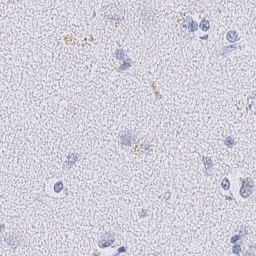

/Users/doug/code/alzheimer/plaquebox-paper/data/tiles/train/NA4009-02_AB/NA4009-02_AB_13_25_1.jpg


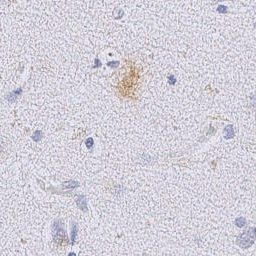

/Users/doug/code/alzheimer/plaquebox-paper/data/tiles/train/NA4009-02_AB/NA4009-02_AB_14_8_0.jpg


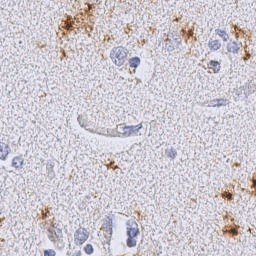

/Users/doug/code/alzheimer/plaquebox-paper/data/tiles/train/NA4009-02_AB/neg_NA4009-02_AB_14_8_0.jpg


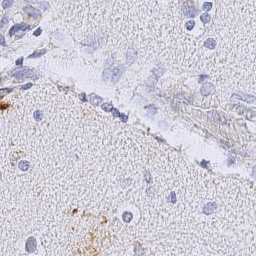

In [25]:
from IPython.display import Image, display

for imageName in dups.iloc[0:4].path.values:
    print(imageName)
    display(Image(filename=imageName))

These files are clearly different. However as missing files were checked for duplicates above this is not a concern for the adjusted dataset.

## Check for image preprocessing (TODO)

Compare a sample of images that were processed using the preprocessing notebooks against the images in the tiles dataset. 

In [ ]:
data_files_index = pd.DataFrame(walk_dir(DATA_DIR))
print(data_files_index.shape)
display(data_files_index.head(2))

In [11]:
sample = data_files_index.sample(2,
                                random_state=2).filename.values
sample

array(['NA4312-02_AB_19_26_3.jpg', 'NA5001_2AB_10_16_79.jpg'],
      dtype=object)

In [12]:
img = sample[0]
data_file = data_files_index.loc[data_files_index.filename == img]
tile_file = tile_files.loc[tile_files.filename == img]

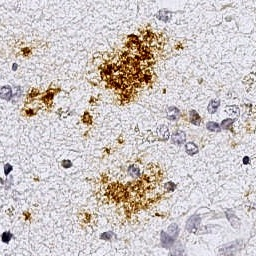

In [17]:
import cv2
import numpy as np
original = cv2.imread(data_file.path.values[0])
duplicate = cv2.imread(tile_file.path.values[0])
from IPython.display import Image
Image(filename=data_file.path.values[0]) 

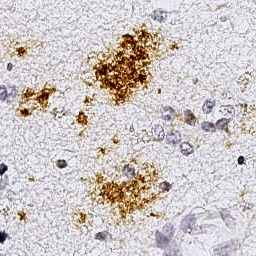

In [15]:
Image(filename=tile_file.path.values[0]) 

In [55]:
train2 = pd.read_csv(tile_files.loc[tile_files.filename == 'train.csv', 'path'].values)

In [56]:
train.equals(train2)

False

In [178]:
train_deduped = train.loc[~train.duplicated(subset='imagename', keep="first")].copy()
train_deduped['adj_imagename'] = train_deduped.imagename.map(lambda s: s.split('/')[-1])
train_deduped['image_folder'] = train_deduped.imagename.map(lambda s: s.split('/')[-2])
assert train_deduped.shape[0] == len(set(train.imagename.values))

In [181]:
# assert there are no duplicate image names
# in a different folder
g = train_deduped.groupby(['image_folder',
                           'adj_imagename'])['imagename'].count()
dfg = pd.DataFrame(g)
dfg.columns = ['image_count']
dfg.reset_index(inplace=True)

assert set(dfg.image_count.values) == {1}

In [106]:
# train_count = train.set_index('adj_imagename').join(dfg.set_index('adj_imagename'),rsuffix='_group')
# train_count.sort_values(['image_count'], ascending=False)

In [187]:
img = 'NA5001_2AB_13_10_32.jpg'
train_deduped.loc[train_deduped.adj_imagename == img]

,id,imagename,cored,diffuse,CAA,negative,flag,notsure,source,adj_imagename,image_folder
9144,6240,NA5001_2AB/NA5001_2AB_13_10_32.jpg,1.0,0.0,1.0,0.0,1.0,0.0,train,NA5001_2AB_13_10_32.jpg,NA5001_2AB


In [161]:
img = 'NA5001_2AB_13_10_32.jpg'
img_names = train_deduped.loc[train_deduped.adj_imagename == img,
               'imagename'].values